# TM10007 Assignment Head and Neck cancer Radiomics

Marie-Claire Doornbos (4492951)
Julia Holdorp (4561651)
Quinten Mank (4336615)
Ylva Weeda (4556038)

 

# Radiomics Pipeline

In this assignment a complete Radiomics Pipeline is composed. After importing all required modules in section 1 the data is loaded and preprocessing methods are defined.

Subsequently, the data is seperated into a train and a test set according to the experimental setup explained below. A standard scaler is used to standardize the training set. The training set is fitted and transformed, while the test set is only transformed (Never touch your test set!!).

Feature selection is applied through either LASSO or PCA, resulting in two different pipelines. After feature selection the following classifiers are applied: Logistic Regression, KNearestNeighbor, Random Forest and Support Vector Machine. To split the data set in a train and test set, for our experimental setup, a repeated KFold cross validation is done, using 5 folds and 50 repeats. In order to find the optimal hyperparameters for each classifier, a random grid search is executed, in which a second cross validation is applied. Inside this cross validation, the training set is once again splitted into a training set and a validation set. The optimal parameters for each classifier are fitted on the train set. 

To evaluate the machine learning algoritm for the prediction of the T-score in head and neck cancer patients, different performance measures are used. The performance is determined by the accuracy, sensitivity and specificity. A ROC is plotted for each classifier,in which performance can be evaluated by the area under the curve (AUC). The performance measures for all classifiers are visualized in a boxplot.

Finally, a learning curve is plotted to evaluate the complexity of the dataset vs. the complexity of the model and to asses possible overfitting. 


In [2]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Importing Modules

In [6]:
# General Packages
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import interp
from scipy.stats import randint

# Load Data
from hn.load_data import load_data

# Classifiers & Kernels
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Pre-processing
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

# Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# Evaluation
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

#Learning curves
from heapq import nlargest
from sklearn.model_selection import learning_curve


## 1. Data loading and Preprocessing
The Head and Neck cancer dataset is loaded into the script. If the dataset contains any missing values or NaN, the missing value is imputed with the mean of the feature in question. The data is scaled using a StandardScaler. Eventually, the data is split into feature values and labels (high risk (1) or low risk (0)). The amount of high-risk and low-risk patients is printed as an output. 


1.1 Load data

In [7]:
def load_check_data():
    '''
    Check if the datafile exists and is valid before reading. Impute missing data.
    '''
    # Check whether datafile exists
    try:
        data = load_data()
        print(f'The number of samples: {len(data.index)}')
        print(f'The number of columns: {len(data.columns)}')
    except FileNotFoundError:
        return print("The csv datafile does not exist"), sys.exit()
    except pd.errors.ParserError:
        return print('The csv datafile is not a proper csv format.'
                     'Please provide a data file in csv format.'), sys.exit()
    # Check whether data is missing.
    # Impute missing or NaN datapoints are with the average of that feature.
    if data.isnull().values.any():
        column_mean = data.mean()
        data = data.fillna(column_mean)
        print('In the csv data file, some values are missing or NaN.'
              'These missing values are replaced by the mean of that feature.')
    return data
data = load_check_data()



The number of samples: 113
The number of columns: 160


1.2 Extract feature values and labels

In [8]:
# Extract features from data
features = data.loc[:, data.columns != 'label'].values

# Extract labels from data
labels = data.loc[:,['label']].values

# Low risk patients receive the label 0 and high risk the label 1
labels = [item if item!='T12' else 0 for item in labels]
labels = [item if item!='T34' else 1 for item in labels]
labels = np.array(labels)

# Number of high and low risk patients is printed
print(f'Number of high risk patients: {np.count_nonzero(labels)}')
print(f'Number of low risk patients: {len(labels) - np.count_nonzero(labels)}')

Number of high risk patients: 55
Number of low risk patients: 58


1.3 Definition to scale the dataset

In [9]:
def scale_data(x, y):
    """
    Scale data with Standard scaler
    """
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x)
    x_test = scaler.transform(y)
    return x_train, x_test



1.4 Splitting the data in training and test
    

In [10]:
def split_sets(x, y):
    """
    Splits the features and labels into a training set (80%) and test set (20%).
    Splitting in the train and test set is shown to provide insight into our method 
    and is used to compute the principal components and alpha for LASSO estimator. 
    """
    # Use repeated stratified KFold
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=None)
    
    # Splitting data into test and training set
    for train_index, test_index in crss_val.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale the data by fitting on the training set and transforming the test set
        x_train, x_test = scale_data(x_train, x_test)
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_sets(features, labels)

# 2. Feature selection
Two different feature selection/extraction tools will be used to find the most distinctive and informative features for analysis. 
1. LASSO (least absolute shrinkage and selection operator): penalizes the absolute sum of weights. 
2. PCA (principal component analysis): finds the directions in which the variance in the highest and rotates data to match. The amount of principal components are calculated base on the train set. 

These two methods will be evaluated and eventually one method will be applied. 


2.1 Compute LASSO 

In [11]:
# Tuning alpha parameter for optimal feature selection with LASSO
test_scores = []
a_max=0
n_alphas = 100
alphas = np.logspace(-2,0,num=n_alphas)

# Loop over range of alphas
for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a)
    clf.fit(pd.DataFrame(x_train).fillna(0), y_train)
        
    # Compute determination coefficient and selecting best alpha
    test_score = clf.score(x_test, y_test)
    if test_score > a_max:
         a_max = test_score
         best_alpha = a
 
# The value used for alpha = 0.040  

def apply_lasso(x1, y, x2, data):
    """
    Apply L1 regularization with best alpha
    """
    numerics = ['int16','int32','int64','float16','float32','float64']
    numerical_vars = list(data.select_dtypes(include=numerics).columns)
    data1 = data[numerical_vars]

    # Apply LASSO with calculated best alpha
    lasso = SelectFromModel(estimator=Lasso(alpha=0.040))
    lasso.fit((pd.DataFrame(x1).fillna(0)),y)
    lasso.get_support()
    selected_feat = data1.columns[(lasso.get_support())]
    print('total features: {}'.format((x1.shape[1])))
    print('features with coefficients shrank to zero: {}'.format(np.sum(lasso.estimator_.coef_ == 0))) 
    
    # Get list of removed features and remove from training and test set
    removed_feats = [(lasso.estimator_.coef_ == 0).ravel().tolist()]
    x_train = lasso.transform(pd.DataFrame(x1).fillna(0))
    x_test = lasso.transform(pd.DataFrame(x2).fillna(0))
    return x_train, x_test



2.2 Compute PCA

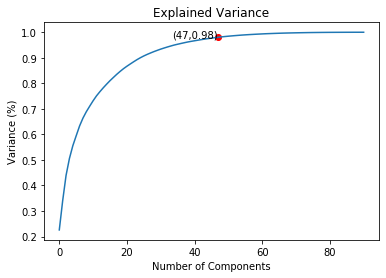

In [12]:
# Computing number of principal components of scaled train data 
pca = PCA().fit(x_train)

# Plot number of components vs. variance, 47 components are used to apply PCA
plt.figure()
plt.scatter(47, 0.98, color='r')
plt.text(47, 0.98, '(47,0.98)', horizontalalignment='right')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()


def apply_pca(x, y):
    """
    Apply PCA with 47 components to data
    """
    pca = PCA(n_components=47)
    pca.fit(x)
    x_train = pca.transform(x)
    x_test = pca.transform(y)
    return x_train, x_test



## 3. Validation
In this section the feature selection methods, LASSO and PCA, are compared with eachother and evaluated on the training set. From this, one feature selection method will be chosen to apply to the final pipeline. 
Furthermore, for each classifier the hyperparameter optimalization method is evaluated to determine wheter a Randomsearch yields a better performing model.


3.1. Classifier Pipeline for Validation

3.2. LASSO vs. PCA
- Analyse whether LASSO or PCA works better! 

3.3. Hyperparameters optimalisation vs. no optimalisation
- Analyse whether the hyperparameter optimalisation works better! 

3.4. Selection of Classifiers ??

## 4. Evaluation of the Model

Based on the validation of the model on the training set, the best model is composed. In this section the performance of the model is evaluated on the test set, to see how accurate the model is able to predict the T stage in Head and Neck Cancer. An accuracy of 70% is pursued.

The area under the ROC curve is plotted and accuracy, sensitivity and specificity are computed using a confusion matrix. All performance measures are visualized in a boxplot. 


4.1. Compute Performance Measures

In [13]:
def compute_performance(model, x, y):
    """ 
    Get Performances on test set
    """
    base_fpr = np.linspace(0, 1, 101)
    # Predict labels for dataset
    prediction = model.predict(x)

    # Create Dataframe and confusion matrix
    performance_scores = pd.DataFrame()
    auc_scores.append(roc_auc_score(y, prediction))
    conf_mat = confusion_matrix(y, prediction)
    total = sum(sum(conf_mat))

    # Calculate performance measures and append to dataframe
    accuracies.append((conf_mat[0, 0]+conf_mat[1, 1])/total)
    sensitivities.append(conf_mat[0, 0]/(conf_mat[0, 0]+conf_mat[0, 1]))
    specificities.append(conf_mat[1, 1]/(conf_mat[1, 0]+conf_mat[1, 1]))
    performance_scores['Accuracy'] = accuracies
    performance_scores['AUC'] = auc_scores
    performance_scores['Sensitivity'] = sensitivities
    performance_scores['Specificity'] = specificities

    # Compute variables for ROC curve
    predicted_probas = model.predict_proba(x)[:, 1]
    fpr, tpr, _ = roc_curve(y, predicted_probas)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    return performance_scores, tprs, aucs

    

4.2 Plot ROC curves

In [14]:
def plot_ROC(tprs, aucs, name):
    """
    Plot ROC curve with AUC for each classifier
    """
    base_fpr = np.linspace(0, 1, 101)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.figure(figsize=(12, 8))
    plt.plot(base_fpr, mean_tprs, 'c', alpha=0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='c', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=0.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title(f'Receiver operating characteristic (ROC) curve {name}')
    plt.grid()
    plt.show()
    return



4.3 Generate Boxplot

In [15]:
def create_boxplot(performance_clf, names):
    """
    Create boxplot of performance measures for all classifiers
    """
    # Store performance measures for each classifier in dataframe
    data1 = pd.DataFrame(performance_clf[0], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=1)
    data2 = pd.DataFrame(performance_clf[1], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=2)
    data3 = pd.DataFrame(performance_clf[2], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=3)
    data4 = pd.DataFrame(performance_clf[3], columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity']).assign(Location=4)
    
    # Fuse dataframes
    cdf = pd.concat([data1, data2, data3, data4])
    mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Index'])

    # Generate boxplot
    ax = sns.boxplot(x="Location", y="value", hue="Index", data=mdf)    
    plt.xticks([0, 1, 2, 3], names)
    ax.set_xlabel('Classifier')
    ax.set_ylabel('Performance')
    plt.show()
    return

4.4 Classifier Pipeline for evaluation on test set

array([0.5       , 0.72222222, 0.83333333, 0.83333333, 0.77777778])
0.7333333333333334
'Performance Logistic Regression Classifier with Hyperparameters:'
'0.6956521739130435'
'Improvement of 7.499151679674245%'
array([0.61111111, 0.66666667, 0.66666667, 0.66666667, 0.61111111])
0.6444444444444444
'Performance Logistic Regression Classifier with Hyperparameters:'
'0.6739130434782609'
'Improvement of 4.139803189684428%'
array([0.5       , 0.72222222, 0.77777778, 0.61111111, 0.72222222])
0.6666666666666667
'Performance Logistic Regression Classifier with Hyperparameters:'
'0.7246376811594203'
'Improvement of 11.978282999660676%'
array([0.68421053, 0.83333333, 0.72222222, 0.77777778, 0.66666667])
0.7368421052631579
'Performance Logistic Regression Classifier with Hyperparameters:'
'0.7025691699604742'
'Improvement of 8.568035290125547%'
array([0.68421053, 0.66666667, 0.77777778, 0.72222222, 0.61111111])
0.6923976608187135
'Performance Logistic Regression Classifier with Hyperparameters:'
'

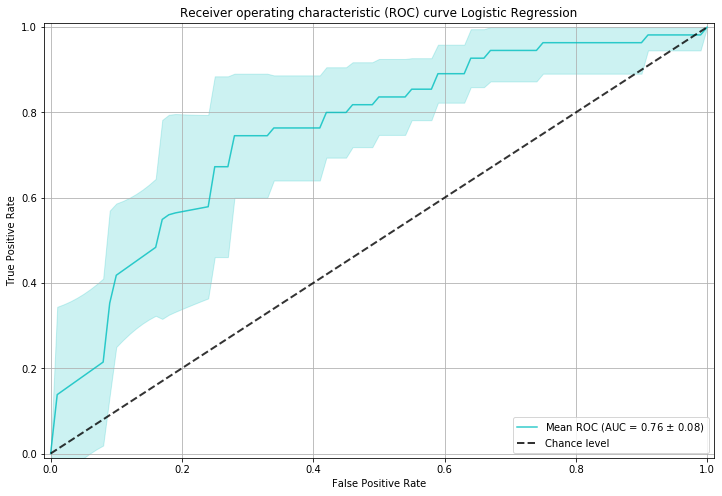

array([0.66666667, 0.72222222, 0.72222222, 0.66666667, 0.83333333])
0.7222222222222222
'Performance kNN Classifier with Hyperparameters:'
'0.5652173913043478'
'Improvement of -12.65693926026468%'
array([0.5       , 0.66666667, 0.72222222, 0.66666667, 0.72222222])
0.6555555555555556
'Performance kNN Classifier with Hyperparameters:'
'0.6086956521739131'
'Improvement of -5.938242280285026%'
array([0.66666667, 0.66666667, 0.5       , 0.55555556, 0.61111111])
0.6
'Performance kNN Classifier with Hyperparameters:'
'0.6231884057971014'
'Improvement of -3.69867662029182%'
array([0.42105263, 0.66666667, 0.72222222, 0.72222222, 0.66666667])
0.639766081871345
'Performance kNN Classifier with Hyperparameters:'
'0.6492094861660079'
'Improvement of 0.32236172378690964%'
array([0.73684211, 0.61111111, 0.61111111, 0.77777778, 0.61111111])
0.6695906432748538
'Performance kNN Classifier with Hyperparameters:'
'0.6375494071146245'
'Improvement of -1.479470648116728%'
Performance kNN Classifier:
      Ac

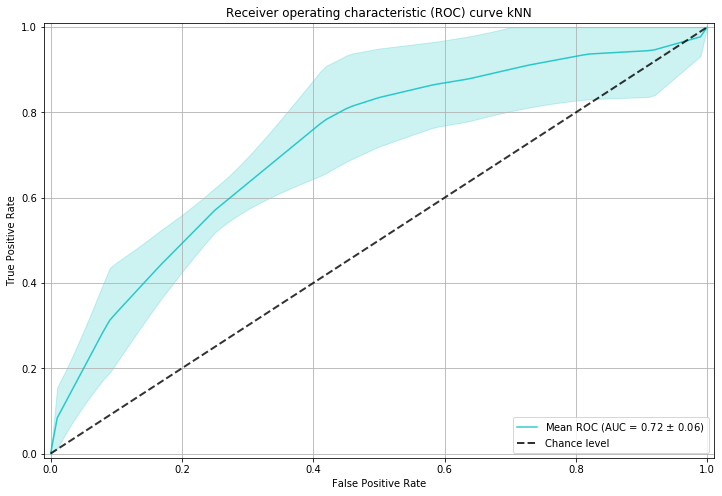

KeyboardInterrupt: 

In [16]:
# Classifier Pipeline PCA

clsfs = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
names = ['Logistic Regression', 'kNN', 'Random Forest', 'SVM']
param_distributions = [{}, {'leaf_size': randint(1, 50),
                        'n_neighbors': randint(1, 20), 'p': [1, 2]}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 30), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]

performance_clf = []

for clf, name, param_dist in zip(clsfs, names, param_distributions):
    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
    performance_scores = []
    bas2line_performance = []
    for train_index, test_index in crss_val.split(features, labels):
        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply PCA to data
        x_train, x_test = apply_pca(x_train, x_test)

        # RandomSearch for optimalization Hyperparameters
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model = random_search.fit(x_train, y_train)
        model = model.best_estimator_
        base_model = clf.fit(x_train, y_train)

        # Evaluate performance on validation set
        scores = cross_val_score(model, x_train, y_train, cv=5)
        pprint(scores)
        pprint(scores.mean())

        # Evaluate performance Hyperparameters on test set
        #baseline_performance, tprs, aucs = compute_performance(base_model, x_test, y_test)
        performance_scores, tprs, aucs = compute_performance(model, x_test, y_test)
        #baseline_performance.append(baseline_performance)
        performance_scores.append(performance_scores)
        #base_accuracy = baseline_performance['Accuracy'].mean()
        random_accuracy = performance_scores['Accuracy'].mean()
        
        #pprint(f'Performance {name} Classifier at baseline:')
        #pprint(f'{base_accuracy}')
        pprint(f'Performance {name} Classifier with Hyperparameters:')
        pprint(f'{random_accuracy}')
        pprint(f'Improvement of {100 * (random_accuracy - base_accuracy) / base_accuracy}%')

    performance_scores.loc['mean'] = performance_scores.mean()
    print(f'Performance {name} Classifier:')
    print(f'{performance_scores}')
    
    # Plot ROC curves
    plot_ROC(tprs, aucs, name)

    performance_clf.append(performance_scores)

# Create boxplot
create_boxplot(performance_clf, names)


In [26]:
# Classifier Pipeline Lasso

clsfs = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True, max_iter=10**6)]
names = ['Logistic Regression', 'kNN', 'Random Forest', 'SVM']
param_distributions = [{}, {'leaf_size': randint(1, 50),
                        'n_neighbors': randint(1, 20), 'p': [1, 2]}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 30), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]

performance_clf = []

for clf, name, param_dist in zip(clsfs, names, param_distributions):
    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
    for train_index, test_index in crss_val.split(features, labels):
        x_train, x_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Scale data with Standard Scalar
        x_train, x_test = scale_data(x_train, x_test)

        # Apply LASSO to data
        x_train, x_test = apply_lasso(x_train, y_train, x_test, data)

        # RandomSearch for optimalization Hyperparameters
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
        model = random_search.fit(x_train, y_train)
        model = model.best_estimator_
        #models.append(model)

        # Evaluate performance on test data
        performance_scores, tprs, aucs = performance(model, x_test, y_test)
        performance_scores.loc['mean'] = performance_scores.mean()
        print(f'Performance {name} Classifier:')
        print(f'{performance_scores}')
    
    # Plot ROC curves
    plot_ROC(tprs, aucs, name)
    performance_clf.append(performance_scores)

    # Create boxplot
    create_boxplot(performance_clf, names)


    # Plot ROC curves
    plot_ROC(tprs, aucs, name)

    performance_clf.append(performance_scores)

# Create boxplot
create_boxplot(performance_clf, names)

total features: 159
features with coefficients shrank to zero: 143
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
Performance Logistic Regression Classifier:
      Accuracy       AUC  Sensitivity  Specificity
0      0.73913  0.738636         0.75     0.727273
mean   0.73913  0.738636         0.75     0.727273
total features: 159
features with coefficients shrank to zero: 138


ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

4.5 Learning Curves

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)]
[KNeighborsClassifier(algorithm='auto', leaf_size=27, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='uniform')]
[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=19, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=113,
                       n_jobs=None, oob_score=False, random_stat

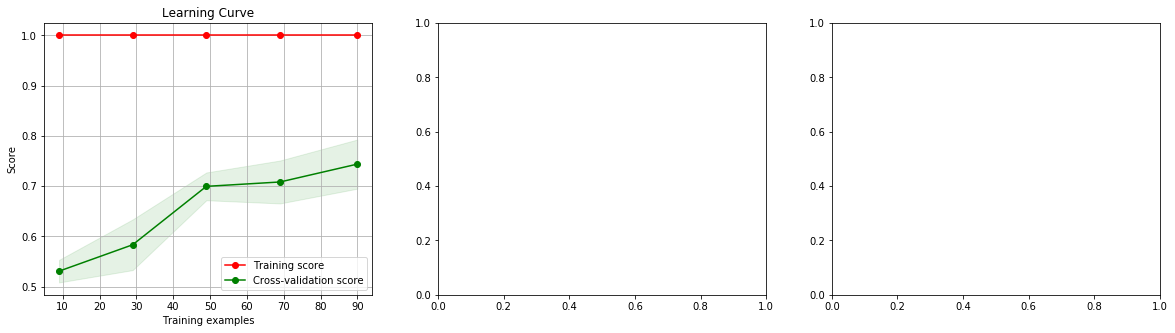

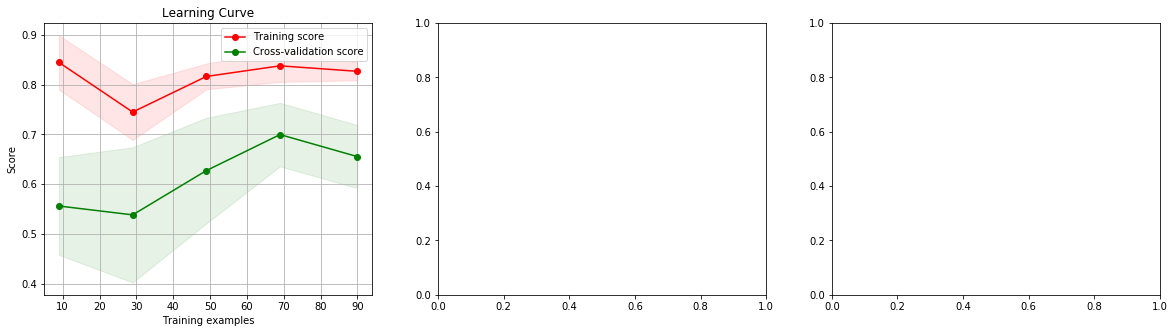

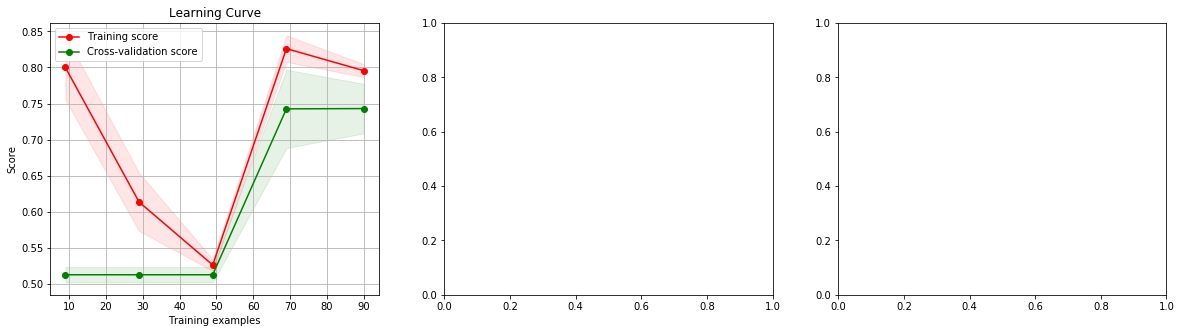

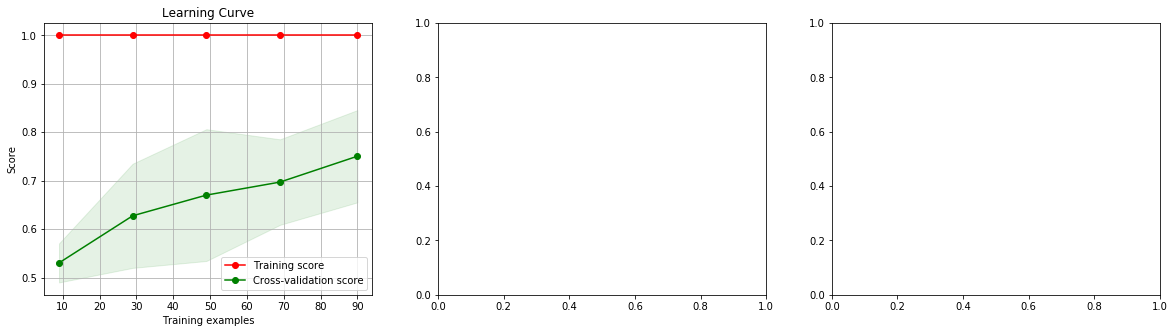

In [21]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(0.1,1,5)):
    """
    definition to plot learning curve from https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes,return_times=True)
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1,color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    axes[0].legend(loc="best")

    return plt

clsfs = [LogisticRegression(),KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
names = ['LR','kNN', 'Random Forest', 'SVM']
param_distributions = [{}, {'leaf_size': randint(1, 50),
                        'n_neighbors': randint(1, 6), 'p': [1, 2]}, {'n_estimators': randint(1, 500),
                        'max_features': randint(1, 30), 'max_depth': randint(1, 20),
                        'min_samples_leaf': randint(1, 20)}, {'C': randint(0.1, 100),
                        'gamma': ['auto', 'scale'], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}]


highest_scored_model = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=None) 
for clf, name, param_dist in zip(clsfs, names, param_distributions):
    
    best_models = {}
    
    # Scale= features with Standard Scalar
    X = features
    y = labels
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    
    # RandomSearch for optimalization Hyperparameters for full dataset
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, scoring='accuracy', n_jobs=-1)
    model = random_search.fit(X, y)
    best_model = model.best_estimator_
    best_result = model.best_score_
    best_models[best_model] = best_result
    highest_scored_model = nlargest(1, best_models, key=best_models.get)
    print(highest_scored_model)
    plot_learning_curve(highest_scored_model[0], "Learning Curve", X, y, axes=None, ylim=None, cv=cv, n_jobs=None, train_sizes=np.linspace(0.1,1,5))
